# Training a Phoneme Language Model #
In this notebook I train a language model over English sounds (also known as [phonemes](https://en.wikipedia.org/wiki/Phoneme)). The data for English pronunciations comes from the CMU Pronouncing Dictionary. The pronunciations in the pronouncing dictionary are in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols representing English sounds. So in ARPABET "fish" is pronounced as /F IH1 SH/.

By training on tens of thousands of pronunciations the model will hopefully learn [English phonotactics](https://en.wikipedia.org/wiki/Phonotactics#English_phonotactics), the rules that govern what sounds like a valid English word. For example, /F AH1 N/ ("fun") sounds good, but /NG S ER1/ (maybe represented as "ngsr") does not.


Check out the notebook `Phoneme Exploration.ipynb` if you want to see the model used.

In [6]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from torch.nn import functional as F
from tqdm.notebook import tqdm

from sonorous.languagemodel import LanguageModel, ModelParams, Vocabulary
from sonorous.pronunciationdata import load_pronunciations
from sonorous.utils import split_data

## The Data ##
The data for this model comes from the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), which contains over one hundred thousand pronunciations. Each pronuncation is in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols for representing English speech sounds. In ARPABET the word "fish" is represented by the sequence of phonemes /F IH1 SH/. You can probably guess the first and third sounds. The vowel in the middle has "1" at the end to indicate it has the primary stress.

I'll use the `load_pronunciations` function to load the Pronouncing Dictionary into a Pandas DataFrame.

In [7]:
pronunciations = load_pronunciations()
print(f"There are {len(pronunciations):,} pronunciations.")
print()
print("Sample of 5 pronunciations:")
pronunciations.sample(5)

There are 125,801 pronunciations.

Sample of 5 pronunciations:


,pronunciation,num_phonemes,num_syllables
word,,,
riverbank,"(R, IH1, V, ER0, B, AE2, NG, K)",8,3
rexon,"(R, EH1, K, S, AH0, N)",6,2
pouches,"(P, AW1, CH, AH0, Z)",5,2
iwanicki,"(IH2, V, AH0, N, IH1, T, S, K, IY2)",9,4
cecala,"(CH, EH0, K, AA1, L, AH0)",6,3


Here is the pronunciation for "fish":

In [8]:
pronunciations.loc['fish', 'pronunciation']

('F', 'IH1', 'SH')

And here are all of the pronunciations for the word "tomato":

In [9]:
pronunciations.loc['tomato']

,pronunciation,num_phonemes,num_syllables
word,,,
tomato,"(T, AH0, M, EY1, T, OW2)",6,3
tomato,"(T, AH0, M, AA1, T, OW2)",6,3


## The Model ##
The module `languagemodel.py` contains a class `LanguageModel` that implements a simple neural language model. It's a PyTorch neural network comprised of the following layers:
1. **Embedding layer** to translate each phoneme into a dense vector. Note that in the code this is called the _encoder since it encodes input phonemes into a representation the model can work with.
2. An recurrent neural network (**RNN**) layer that processes each input phoneme sequentially and for each step generates (a) a hidden representation to pass on to the next step and (b) an output.
3. A **linear layer** that decodes the outputes (2b) into distributions over each phoneme. Note that in the code this is called the _docoder since it decodes the model's internal representations back into phonemes.

Let's go through a simple example of what happens when we pass the pronunciation /F IH1 SH/ through the model. Ultimately what I want ouf of the model is a prediction at each position of what the next phoneme should be. For example, when a well trained model is sees /F IH1/ it should know that /SH/ is likely, or at least not unlikely.

First I'll create a `Vocabulary` instance by passing in all the pronunciations. The `vocab` is used to convert phonemes into integer indices that the neural network handle. It does a few other things too, which you can see below. The `Vocabulary` class's code is in `sonorous/languagemodel.py`.

In [10]:
vocab = Vocabulary.from_texts(pronunciations.pronunciation.values)

print(f"There are {len(vocab)} distinct phonemes.")
print()
print("Looking up the int index for 'SH':", vocab['SH'])
print()
print("Checking whether 'SH' is in the vocabulary:", 'SH' in vocab)
print()
print("Looking up the phoneme for a specific int index:", vocab.token_from_idx(vocab['SH']))
print()
print("Encoding /F IH1 SH/:", vocab.encode_text(("F", "IH1", "SH")))

There are 72 distinct phonemes.

Looking up the int index for 'SH': 40

Checking whether 'SH' is in the vocabulary: True

Looking up the phoneme for a specific int index: SH

Encoding /F IH1 SH/: [ 1 54 58 40  2]


Now I'll define the model. Note that I'm not actually fitting the model to any data so the output will be random. The hyperparameters aren't optimal, but again that doesn't matter here since I just want to show the flow of data through the network.

The `ModelParams` class (from `sonorous/languagemodel.py` encapsulates hyperparameters and options for the model).

In [11]:
model_params = ModelParams(
    rnn_type='rnn', embedding_dimension=10, hidden_dimension=3, num_layers=1,
    max_epochs=3, early_stopping_rounds=3
)

language_model = LanguageModel(vocab, model_params, 'cpu')

Now I'll walk through what happens when we pass the word "fish" /F IH1 SH/ through the model:

In [12]:
fish_pronunciation = ("F", "IH1", "SH")

The `Vocabulary.encode_text` function we saw earlier does a few things. First, it adds dummy tokens to the pronunciation indicating its start and end. This allows the model to learn transition probabilities from the start of the word to the first phoneme, and from the last phoneme to the end of the word.

It then converts every phoneme to its ingeter index.


Before passing the pronunciation into the neural network I need to add dummy tokens to the pronunciation indicating its start and end. This allows the model to learn transition probabilities from the start of the word to the first phoneme, and from the last phoneme to the end of the word. We end up with this: `["START", "F", "IH1", "SH", "END"]`.

I also need to translate each phoneme into an integer index within the model. The `encode_pronunciation` function handles both of these tasks. It uses the `phoneme_to_idx` mapping I built above.

In [13]:
fish_input = vocab.encode_text(fish_pronunciation)
print(fish_input)
print()
for idx in fish_input:
    phoneme = vocab.token_from_idx(idx)
    print(f'{idx} => {phoneme}')

[ 1 54 58 40  2]

1 => <START>
54 => F
58 => IH1
40 => SH
2 => <END>


And now we're ready to pass the input into the model's `forward` function, which takes in inputs and outputs predictions. This model's `forward` function expects a Tensor of dimension `(batch_size, NUMBER OF STEPS)`. A step here refers to a step forward in the sequence, so /<START> F IH1 SH <END>/ has 5 steps.

In [14]:
print("Input's shape:", fish_input.shape)
fish_batch_input = torch.LongTensor(fish_input).unsqueeze(0)
print("Batch input's shape:", fish_batch_input.shape)

Input's shape: (5,)
Batch input's shape: torch.Size([1, 5])


The first thing the `forward` function does is embed each phoneme using an [nn.Embedding](https://pytorch.org/docs/stable/nn.html#embedding). Each phoneme has a dedicated embedding vector of length `embedding_dimension`, so the shape of `embedded` is `(batch size, number of steps, embedding_dimension)`.

In [15]:
embedded = language_model._encoder(fish_batch_input)
print(embedded.shape)
print()
embedded

torch.Size([1, 5, 10])



tensor([[[-0.1148, -0.9294,  0.7978,  2.8409, -0.8465, -0.9143, -0.1723,
          -0.1748, -1.2959,  0.9995],
         [ 0.3539,  1.2048,  1.2673,  0.7595, -0.6608,  0.9846, -0.2674,
          -0.3650,  0.5816, -0.0784],
         [ 0.4572, -0.1506,  0.3754, -1.7291,  1.2272, -0.8673,  0.8768,
           0.2749, -0.2253, -0.4616],
         [-0.1591, -0.0765,  0.6621,  0.1541,  0.1481, -1.0852,  0.6191,
           0.5026, -0.8080, -1.0243],
         [-1.3152,  1.2099, -1.2327, -1.3089, -0.2707, -1.0372,  0.3440,
          -2.5274,  0.1378, -0.0653]]], grad_fn=<EmbeddingBackward>)

I'll pass `embedded` to the [RNN layer](https://pytorch.org/docs/stable/nn.html#recurrent-layers), resulting in `rnn_output` and `hidden_state`. I won't go into detail on how RNNs work since there are many detailed posts on the web you can read, but the basic idea is a cell is applied sequentially to every token (i.e. step) in the input. At each step an output and a hidden state are produced. The hidden state can be passed on to the next step, and the output can be used to make a prediction.

The `rnn` layer below operates on the full sequence, so the results are for the entire sequence.

In [16]:
rnn_output, hidden_state = language_model._rnn(embedded)
print(rnn_output.shape)
print()
rnn_output

torch.Size([1, 5, 3])



tensor([[[ 0.2615, -0.2971, -0.5185],
         [ 0.5868, -0.9010,  0.4808],
         [ 0.9676, -0.3534, -0.1497],
         [ 0.8656, -0.3917, -0.1457],
         [ 0.9905,  0.0748, -0.6298]]], grad_fn=<TransposeBackward1>)

For our application we can ignore the `hidden_state`-- the `rnn_output` is the interesting part. The first dimension is for the batch, and we only have a single input in our batch. The second dimension is for each of the input phonemes. The third dimension corresponds to `hidden_dimension`: you can think of this as the state of the RNN at each step.

As I said at the beginning of this section, I want the output of the RNN at each position to be predictions for the *next* position. So I'll apply a [linear layer](https://pytorch.org/docs/stable/nn.html#linear) to the `rnn_output`, resulting in a vector the size of the vocabularly at each position. The [softmax](https://pytorch.org/docs/stable/nn.functional.html#softmax) function normalizes the outputs into probability distributions for each prediction.

In [17]:
outputs = language_model._decoder(rnn_output)
probabilities = F.softmax(outputs, dim=-1).squeeze()
probabilities.shape

torch.Size([5, 72])

The shape of `probabilities` is (5, 72) because each of the five tokens in `/<START> F IH1 SH <END>/` gets a a probability distribution over each of the 72 phonemes in the vocabulary.

The first phoneme in the input is the `<START>` token; let's see what the model thinks should come next.

In [18]:
probabilities_for_first_phoneme = probabilities[0]
most_likely_first_phoneme_idx = probabilities_for_first_phoneme.argmax().item()
most_likely_first_phoneme = vocab.token_from_idx(most_likely_first_phoneme_idx)
most_likely_first_phoneme

'JH'

So the model predicts /F/ to be the first phoneme in the word. Since the model isn't fit yet this is just a random guess. In order to get the model to make good predictions I'll need to first train a good model.

## Finding the Best Model ##
In this section I'll train a number of models on the train set and select the one that has the lowest error on the dev set. I'll split the DataFrame of pronunciations into three DataFrames, with 79% for training, 20% for dev/validation, and 1% for testing of the final model.

In [19]:
train_pronunciations, dev_pronunciations, test_pronunciations = split_data(pronunciations, dev_proportion=.2, test_proportion=.01)
len(train_pronunciations), len(dev_pronunciations), len(test_pronunciations)

(99382, 25160, 1259)

Note that I ran a larger parameter search before and saw that GRUs were consistently outperforming LSTMs and vanilla RNNs. There are 12 (4 * 3) models to train, and for each one I'm measuring train and dev error at every epoch. So if each model trains for the maximum of 2,000 epochs I would end up with 12 * 2,000 = 24,000 models to choose from. There's a good chance I'm overfitting the dev set with such a large search, but I'll inspect the learning curves to try to avoid selecting an iteration that randomly did well.

While each model trains for a maximum of 2000 epochs, it stops early if the dev error does not decrease for three epochs in a row. Since I'm going to be selecting the model with the lowest dev error there's no reason to keep training a model once it's started overfitting. Alternatively I could train all models to convergence and then add regularization to reduce the complexity and identify the sweet spot, but that's far more time consuming because it requires training more models and each of them for longer.

In [20]:
train_pronunciations

,pronunciation,num_phonemes,num_syllables
word,,,
tab,"(T, AE1, B)",3,1
lochhead,"(L, AA1, K, HH, EH2, D)",6,2
consultations,"(K, AA2, N, S, AH0, L, T, EY1, SH, AH0, N, Z)",12,4
indosuez,"(IH1, N, D, OW0, S, UW0, EH0, Z)",8,4
entwisle,"(EH1, N, T, W, AY0, AH0, L)",7,3
...,...,...,...
continentally,"(K, AA2, N, T, AH0, N, EH1, N, T, AH0, L, IY0)",12,5
blemishes,"(B, L, EH1, M, IH0, SH, IH0, Z)",8,3
thousandth,"(TH, AW1, Z, AH0, N, D, TH)",7,2


In [49]:
from sonorous.analysis_utils import plot_next_phoneme_distribution, plot_pronunciation_probability

In [59]:
%%time

large_model_parameters = ModelParams(rnn_type='gru', max_epochs=10000, early_stopping_rounds=3,
                              embedding_dimension=100, hidden_dimension=100, num_layers=3)
large_model = LanguageModel(vocab, large_model_parameters, device_name='cuda')

large_model.fit(train_pronunciations.pronunciation.values.tolist(), dev_pronunciations.pronunciation.values.tolist())

Epoch 1: train loss: 0.8523	dev loss: 1.1573
	Generated: in train: 8%, assess: 0%, novel: 92%
	 AY0
	 R L AH0 UW1 B S
	 ER0 M OY1 IY0 IH0
	 
	 F AY1 D ER0 R
Epoch 2: train loss: 0.7747	dev loss: 1.0539
	Generated: in train: 3%, assess: 0%, novel: 97%
	 EH1 K AH0 N F
	 UW2 IH1 N JH
	 T P N IY1 Z ER0
	 Z B AW1 Z ER0
	 IY2 OY0 AW1 AH0 ER0 B IH2
Epoch 3: train loss: 0.7006	dev loss: 0.9535
	Generated: in train: 7%, assess: 0%, novel: 93%
	 UH0 R IY1 L HH AO1 TH
	 B EH1 N R AH0 G
	 SH AA1 T AH0 L ER0
	 K OW1 L AH0 F B IY0 S AE1 K
	 K AE1 M D IY0
Epoch 4: train loss: 0.6737	dev loss: 0.9178
	Generated: in train: 3%, assess: 2%, novel: 95%
	 JH AE1 N B B AH0 M
	 R EH1 K D IH0 N
	 B L AA0 R M IH1 K T AH0 S
	 Z AH1 TH S AA2 V
	 R EH1 R D Y AA1 R D
Epoch 5: train loss: 0.6545	dev loss: 0.8923
	Generated: in train: 11%, assess: 3%, novel: 86%
	 K AO1 M IY0 AH0 SH ER0 UW2 T
	 R IH1 M ER0 S
	 N EH1 V AH0 T AE1 N
	 G AA0 N D EH2 S EY1 AH0 N
	 S AA1 D IH0 K
Epoch 6: train loss: 0.6411	dev loss: 0.874

Epoch 42: train loss: 0.5469	dev loss: 0.7786
	Generated: in train: 18%, assess: 1%, novel: 81%
	 M AW1 L EY2 K S
	 M AO1 R OW0 Z
	 K R IH1 JH ER0 Z
	 IH2 N S AE2 K Y AH0 L EH1 F R AH0 K EY2 T IH0 D
	 R OW1 D AH0 L
Epoch 43: train loss: 0.5454	dev loss: 0.7775
	Generated: in train: 17%, assess: 4%, novel: 79%
	 EH1 S T IH0 V
	 F EY1 G ER0 W UH2 M AH0 N
	 D IY0 M AA0 V IY0 AA1 N OW0
	 G AO1 R IH0 N
	 R IH1 CH L IH0 K
Epoch 44: train loss: 0.5447	dev loss: 0.7773
	Generated: in train: 15%, assess: 2%, novel: 83%
	 B R IH1 N T S
	 S L AE1 M D
	 P R IH0 F R UW1 D
	 Y UW1 R OW0 K OW2 T
	 AW1 S L AH0 N D
Epoch 45: train loss: 0.5438	dev loss: 0.7777
	Generated: in train: 15%, assess: 1%, novel: 84%
	 R IY2 K AO1 M AH0 Z
	 T EH1 R K AH0
	 JH UW0 L EH1 T S
	 S T UW1 M EH0 N S T
	 S T OW1 L IH0 NG
Epoch 46: train loss: 0.5426	dev loss: 0.7767
	Generated: in train: 19%, assess: 4%, novel: 77%
	 R AE1 N D IY0
	 P AA1 K S AH0 N
	 Y ER0 IY1 K IY0
	 R OW0 D IH1 S T AH0 N
	 EH1 L IH0 SH
Epoch 47: tra

Epoch 85: train loss: 0.5133	dev loss: 0.7788
	Generated: in train: 33%, assess: 0%, novel: 67%
	 S ER1 JH D
	 K R AE1 R IH0 NG T AH0 N
	 F AO1 L F ER0
	 V ER0 N AE1 N D AH0
	 AA1 R P S
Epoch 86: train loss: 0.5127	dev loss: 0.7784
	Generated: in train: 22%, assess: 3%, novel: 75%
	 K IH1 NG D AH0 N L AY2 N
	 AE1 M Y UW2 Z
	 S W EH1 S AH0 K
	 K AH0 P EY1 N
	 SH IH1 T IH0 T S
Epoch 87: train loss: 0.5123	dev loss: 0.7789
	Generated: in train: 24%, assess: 2%, novel: 74%
	 N AO1 R B AA2 K S
	 IY1 N AW2 T S
	 R AE1 CH AH0 T IH0 D
	 T EY1 Z
	 P IH0 N D AO1 R
Epoch 88: train loss: 0.5115	dev loss: 0.7784
	Generated: in train: 28%, assess: 1%, novel: 71%
	 AA1 K S EH0 R
	 L EH1 B AH0 N
	 B R AH1 S IY0
	 OW0 L IY1 N IY0
	 R IH0 S P OW1 Z
Epoch 89: train loss: 0.5111	dev loss: 0.7791
	Generated: in train: 25%, assess: 1%, novel: 74%
	 N AA1 K S IY0
	 B R IH1 M T
	 G OW2 L AO1 W IH0 N
	 S EH1 D IH0 G
	 S G AO1 R N AH0 L D
Epoch 90: train loss: 0.5109	dev loss: 0.7794
	Generated: in train: 36%, 

Epoch 126: train loss: 0.4975	dev loss: 0.7888
	Generated: in train: 34%, assess: 3%, novel: 63%
	 M EY1 N IY0 B OW0
	 Z AA0 F IY0 AA1 R AH0
	 S AE1 T ER0 D IY0 Z
	 AA0 B IY1 K IY2
	 HH EY1 P CH IH0 Z
Epoch 127: train loss: 0.4969	dev loss: 0.7882
	Generated: in train: 31%, assess: 0%, novel: 69%
	 K AA1 M ER0 AH0 N
	 S IH1 L K
	 S AH1 K ER0
	 B EH1 R AH0 N HH IH0 B AH0 S
	 AE1 M B UH0 L
Epoch 128: train loss: 0.4967	dev loss: 0.7886
	Generated: in train: 28%, assess: 3%, novel: 68%
	 G R AH0 M AE1 T S K IY0
	 F AO1 F T
	 W IH1 N D
	 N UW1 K OW0
	 V IH1 L Y AH0 N Z
Epoch 129: train loss: 0.4965	dev loss: 0.7891
	Generated: in train: 26%, assess: 3%, novel: 71%
	 W EY1 L AH0 N Z
	 K EY1 V
	 F UW2 B OW0 D EH1 S T OW0
	 B AH0 D AA1 S K IY0
	 OW1 HH Y UW2
Epoch 130: train loss: 0.4962	dev loss: 0.7891
	Generated: in train: 28%, assess: 1%, novel: 70%
	 D Y UW1 R AH0
	 K R EH2 B L AH0 V IH1 R IY0 AH0 N
	 V IH1 K S IY0 ER0
	 M AH0 G AE1 R AH0 M AH0 N
	 P ER0 P AO1 R T S
Epoch 131: train loss

Epoch 168: train loss: 0.4880	dev loss: 0.7979
	Generated: in train: 32%, assess: 0%, novel: 68%
	 L IH0 S AA1 T AH0
	 F AH0 L AA1 JH IH0 K AH0 L
	 IY1 Z AH0
	 AH0 JH EH1 S T IH0 B AH0 L
	 M IH1 SH AH0 L
Epoch 169: train loss: 0.4878	dev loss: 0.7984
	Generated: in train: 30%, assess: 1%, novel: 69%
	 D OW1 T IY0
	 AE2 M AH0 G R AA1 T OW0
	 R IH1 CH AH0 K IH0 Z
	 IH2 M P AH1 L S
	 S IH0 G AA1 R S K IY0
Epoch 170: train loss: 0.4878	dev loss: 0.7982
	Generated: in train: 22%, assess: 0%, novel: 78%
	 IH0 K S P EY1
	 L IH1 S AH0 N
	 S T EY1 T S L AH0 S
	 N AE1 T S IY2 S
	 T AH1 L ER0 Z
Epoch 171: train loss: 0.4872	dev loss: 0.7977
	Generated: in train: 28%, assess: 1%, novel: 71%
	 P ER0 HH EH1 N
	 JH ER0
	 AE0 M G AH1 V AH0 L
	 W IH1 N IH0 K AH0 N
	 R OW1 D AH0 N
Epoch 172: train loss: 0.4873	dev loss: 0.7985
	Generated: in train: 24%, assess: 1%, novel: 75%
	 F EY1 ER0 T
	 D EH1 N G AH0 L
	 N AH0 V IH1 N IY0 AH0
	 HH EH1 D W EY2
	 K R AH0 S AO1 F S K IY0
Epoch 173: train loss: 0.4870	

Epoch 210: train loss: 0.4822	dev loss: 0.8052
	Generated: in train: 25%, assess: 0%, novel: 75%
	 P IY0 K AA1 R D IY0
	 OW1 P AH0 N F IY2 L D
	 D IH0 S AE1 N D AH0 D
	 AA2 F TH AH0 M AH0 L EY1 SH AH0 N
	 B EH1 JH IH0 S AH0 N
Epoch 211: train loss: 0.4821	dev loss: 0.8050
	Generated: in train: 30%, assess: 1%, novel: 69%
	 T AY1 G ER0
	 F AO1 R M AH0 L D
	 P AW1 AH0 L IH0 NG
	 Z IY1 L
	 R EH1 S N AH0 L
Epoch 212: train loss: 0.4826	dev loss: 0.8058
	Generated: in train: 33%, assess: 2%, novel: 65%
	 M AE1 R IH0 K AH0 L
	 K AE1 L OW0
	 N Y UW1 N
	 K AA0 R AA0 NG G AA1 L OW0
	 K L AE1 S IH0 V L IY0
Epoch 213: train loss: 0.4819	dev loss: 0.8055
	Generated: in train: 36%, assess: 2%, novel: 62%
	 N UW1 Z P UH2 K
	 HH EY1 Z OW0
	 S T IH1 L T S AA0 K S
	 F AO1 S EH0 K
	 HH AA1 L AH0 D EH0 N S AH0 N
Epoch 214: train loss: 0.4815	dev loss: 0.8047
	Generated: in train: 38%, assess: 2%, novel: 60%
	 P IH0 N T R EY1 OW0
	 K OW1 L AH0 N
	 IH0 K S EH1 D AH0 B EH2 R IH0 NG
	 B AE1 T AH0 L HH AW2 S 

Early stopping because of no decrease in 3 epochs.


([0.8522663371812279,
  0.774695183904171,
  0.7005750829841965,
  0.6736818527104276,
  0.6544779821982142,
  0.6411146413808692,
  0.6311410802123005,
  0.6231083743285457,
  0.6166366533032211,
  0.611380981233227,
  0.6069176330113984,
  0.6023655573974833,
  0.5991568798495012,
  0.595621835890137,
  0.5925793480737324,
  0.5902473493465005,
  0.5867781195486675,
  0.5849196228083435,
  0.5823970749870594,
  0.5804378709144846,
  0.5778552285030669,
  0.5762862158427166,
  0.5741570046851129,
  0.5720648462028212,
  0.5722479968523182,
  0.569406383025876,
  0.567031253553864,
  0.5657163614071158,
  0.5637833905208997,
  0.5622155829602464,
  0.5613909089193351,
  0.5600348549625881,
  0.5583203058221751,
  0.5564434296276837,
  0.5557063265400749,
  0.5547144497935391,
  0.5532551087596346,
  0.5514842191663425,
  0.5505223234586489,
  0.5496974675278704,
  0.5483444885436922,
  0.5468560833105165,
  0.5454440343381014,
  0.5447333954380061,
  0.5438469010539169,
  0.54264641992

In [60]:
%%time

huge_model_parameters = ModelParams(rnn_type='gru', max_epochs=10000, early_stopping_rounds=3,
                              embedding_dimension=500, hidden_dimension=500, num_layers=3)
huge_model = LanguageModel(vocab, huge_model_parameters, device_name='cuda')

huge_model.fit(train_pronunciations.pronunciation.values.tolist(), dev_pronunciations.pronunciation.values.tolist())

Epoch 1: train loss: 0.6771	dev loss: 0.9227
	Generated: in train: 12%, assess: 1%, novel: 87%
	 IH2 N EH1 S T AH0 L
	 JH EY1 M AH0 N T IY0
	 AE1 L B R IY0
	 S AO1 CH TH L
	 SH UW1 G AH0
Epoch 2: train loss: 0.6202	dev loss: 0.8472
	Generated: in train: 13%, assess: 1%, novel: 86%
	 T EH1 NG G AH0
	 W IH1 T ER0 AH0 N
	 HH AY1 M AH0 N
	 S ER1 R AY0 JH D
	 L IY0 D AA0 R S K R EH1 K T IH0 D OW0
Epoch 3: train loss: 0.5976	dev loss: 0.8195
	Generated: in train: 14%, assess: 0%, novel: 86%
	 N OW1 K AH0
	 V AA2 N OW0 K AE1 K AH0
	 HH IH1 D IY0
	 W AO1 D IY0
	 P ER0 K Y UW1 T IH0 V
Epoch 4: train loss: 0.5847	dev loss: 0.8057
	Generated: in train: 9%, assess: 5%, novel: 86%
	 CH IH1 L IH0 NG
	 R AA1 CH AE0 K
	 P AA2 L AH0 V EH1 L IY0 AH0
	 L AE1 NG IH0 G IH2 N SH P EY2 D
	 K R IH1 P IH0 NG T AH0 N
Epoch 5: train loss: 0.5735	dev loss: 0.7941
	Generated: in train: 11%, assess: 1%, novel: 88%
	 K L AW1 D IH0 NG ER0
	 AH0 P ER1 Z AH0 D AY2 IH0 NG
	 IH0 M P R UH2 K L EY1
	 D AY0 IY1 N
	 JH AE1 G

Epoch 43: train loss: 0.4003	dev loss: 0.8129
	Generated: in train: 73%, assess: 2%, novel: 25%
	 S AA1 K IH0 NG
	 S T R IH1 P T AY2 D
	 K AA1 N K ER0
	 N IY1 D IH0 NG
	 JH EH1 S AH0 M IH0 N
Epoch 44: train loss: 0.3993	dev loss: 0.8139
	Generated: in train: 64%, assess: 1%, novel: 35%
	 S ER2 K AH0 M S T AE1 N SH AH0 L IY2
	 P EY1 AH0 N
	 K R IH2 S T IY0 AE1 N AH0
	 K AE2 N IH0 B IY0 AA1 N OW0
	 K AA1 M P L AH0 M EH2 N IH0 NG
Epoch 45: train loss: 0.3983	dev loss: 0.8167
	Generated: in train: 69%, assess: 1%, novel: 30%
	 L IH1 R AH0
	 K AH0 N K L UW1 D
	 M OW1 M AH0 N T R IY0
	 F R AE1 N T AH0
	 G AA1 L
Epoch 46: train loss: 0.3985	dev loss: 0.8177
	Generated: in train: 76%, assess: 1%, novel: 23%
	 HH EH1 NG L ER0
	 P R AE1 NG K
	 L AE1 K AH0 L Z
	 S T UW1
	 K EH1 N ER0 S AH0 N
Epoch 47: train loss: 0.3981	dev loss: 0.8184
	Generated: in train: 79%, assess: 0%, novel: 21%
	 N AH2 SH AH0 N AH0 G R AE1 F IH0 K
	 F EH1 R AH0
	 N EH1 R IY0
	 B EH0 L AA1 R AH0 S
	 HH AO1 K S
Epoch 48: tr

Epoch 85: train loss: 0.3916	dev loss: 0.8438
	Generated: in train: 78%, assess: 0%, novel: 22%
	 S AE1 N S T OW2 N
	 EH1 N AH0 N
	 K R IH1 R
	 S AH1 B S IH0 D IY0 Z
	 K AH0 T AE1 L IH0 T IY0 Z
Epoch 86: train loss: 0.3912	dev loss: 0.8425
	Generated: in train: 90%, assess: 0%, novel: 10%
	 P AH0 D OW1 L IY0 AH0
	 EH1 V AH0 D AH0 N T L IY0
	 D R EH1 N CH ER0
	 IH1 N T ER0 P R EH2 T IH0 NG
	 M AH1 N CH IY2 Z
Epoch 87: train loss: 0.3914	dev loss: 0.8417
	Generated: in train: 83%, assess: 1%, novel: 16%
	 K AO1 R IH0 N
	 AH1 N D ER0 K L AE2 S
	 HH OY1 S T
	 W AO1 R NG K IY0
	 B EY1 L IY0
Epoch 88: train loss: 0.3911	dev loss: 0.8435
	Generated: in train: 84%, assess: 1%, novel: 15%
	 AE1 M IY2 T ER0
	 S AH1 N D IY0 N
	 K AO1 R AH0 L EY2 T AH0 D
	 D IH0 P OW1 Z D
	 M AA0 JH IY1 S T R OW0
Epoch 89: train loss: 0.3910	dev loss: 0.8448
	Generated: in train: 82%, assess: 3%, novel: 15%
	 AA0 L B IY1 N IY0 AH0
	 AH0 S ER1 T
	 D IH0 R EH1 K T IH0 V Z
	 L AA0 R EY1 Y AH0
	 W IH1 D M AH0 N
Epoch 

Early stopping because of no decrease in 3 epochs.


([0.6771201123038031,
  0.6201778227237296,
  0.5975773036152485,
  0.584715890885359,
  0.573504187539967,
  0.5635658067786656,
  0.5540268645180012,
  0.5455008053694357,
  0.5344762440967209,
  0.5242886154435715,
  0.5167726389991842,
  0.5069822011301,
  0.4970988130965775,
  0.4911501865505058,
  0.48003158223878256,
  0.47162510426496296,
  0.4650845957878085,
  0.4581809647545988,
  0.4518797466765837,
  0.4465689766549594,
  0.4410518358230885,
  0.4356727909576561,
  0.4317179799865971,
  0.4281022646878281,
  0.4247880636464208,
  0.42125179174109145,
  0.4183967142772412,
  0.416083993562639,
  0.4152372608357671,
  0.41237252525539475,
  0.412377625848512,
  0.40943684396736546,
  0.4081086940657521,
  0.40711302821652656,
  0.4063645322928052,
  0.4050508863117163,
  0.403708272409133,
  0.4026946815949849,
  0.4019463490548347,
  0.4020293275807118,
  0.4009621361052974,
  0.4009164797629035,
  0.4003150140475561,
  0.3993179764191401,
  0.3983474975773457,
  0.39850512

In [24]:
%%time

model_parameters = ModelParams(rnn_type='gru', num_layers=1, max_epochs=1000, early_stopping_rounds=3,
                              embedding_dimension=100, hidden_dimension=3)
model = LanguageModel(vocab, model_parameters, device_name='cuda')

model.fit(train_pronunciations.pronunciation.values.tolist(), dev_pronunciations.pronunciation.values.tolist())

Epoch 1: train loss: 3.3905	dev loss: 3.4817
	Generated: in train: 2%, assess: 0%, novel: 98%
	 OW1 F OW1 IY0 IH2 W AY2 EH0 AW0 T OW1 AA2
	 N AE0
	 M AE1 L AW2 NG Y AH0 EY2 ER1 T P ER1 Z T AY1 UW2 AW1 NG IH0 AE1 N AY1 HH R UW2 UH2 AA1 OW1 Y OW1 IY1 IH1 OY2 EY1 IY0 UW1 UW1 OW1 HH UH2 R EH2 OY0 S P UW2 AE2 OW2
	 D AA0 OW0 OW0 AY1 T UW2 CH ER0 AA1 AH1 P EY1 CH NG OY0
	 UW1 Z AO0 UW0 F IY2 UW2 AA1 UH2 UW2 ZH AW1 OY2
Epoch 2: train loss: 2.8121	dev loss: 2.9644
	Generated: in train: 1%, assess: 0%, novel: 99%
	 
	 IH1 F UW2 AW2 S D OW1 OY0 AY2 AE1 AE2 UW2
	 AA1
	 UW2 IH2 TH EY2
	 IY2 OW1 L EY2 EH1
Epoch 3: train loss: 2.3151	dev loss: 2.5217
	Generated: in train: 0%, assess: 0%, novel: 100%
	 
	 G AA1 R G EH2 AA2 UW0 N UW0 UH1 Z N EH0
	 Y W
	 DH OY0 Z ER2 B UW2 HH T IY0
	 AW2 AO0 G AY2 IY1 Y EY1 HH G
Epoch 4: train loss: 1.9133	dev loss: 2.1624
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AA2 Y AH1 D AA2 NG N M TH IY2 AO2 TH R IH1 OW1 EH1 AE1 N UH2 M EY1
	 B SH OW0 N IH1 AW2 D
	 B NG 

Epoch 40: train loss: 0.7808	dev loss: 1.0589
	Generated: in train: 7%, assess: 0%, novel: 93%
	 M AA1 T AH0 K R AH0 N W N N Z IH0 S AH0 Z D B W NG
	 
	 M IY1
	 M AE2 P N IH0 F IY0 P
	 ER1 K AH0 N T CH
Epoch 41: train loss: 0.7789	dev loss: 1.0564
	Generated: in train: 11%, assess: 0%, novel: 89%
	 AH1 D
	 T IH1 AH0 K Y AH0 L AH0 N IH0 Z IH0 S L AH1 T AH0 L S T IY1 EH2 AH0 AW1 S IH0 N
	 UH1 L AY1 L S AH0 N Y IH0 T AH0 L
	 S V T M
	 N P OW0 IY0
Epoch 42: train loss: 0.7770	dev loss: 1.0540
	Generated: in train: 14%, assess: 0%, novel: 86%
	 K AO1 N IH0 NG
	 K M AO1 S
	 AE1 L
	 F M
	 HH OY1 K AA0 OW2 AE1 K K
Epoch 43: train loss: 0.7745	dev loss: 1.0509
	Generated: in train: 7%, assess: 0%, novel: 93%
	 
	 D R AH0 L T AH0 SH
	 IY1 L
	 F ER1 T AH0 S
	 B IH1 OY1
Epoch 44: train loss: 0.7730	dev loss: 1.0490
	Generated: in train: 10%, assess: 1%, novel: 89%
	 
	 W S IY0 EH1
	 L
	 B AH0 R OW1 N Z IY0
	 S B EH1 S
Epoch 45: train loss: 0.7707	dev loss: 1.0462
	Generated: in train: 12%, assess:

Epoch 83: train loss: 0.7297	dev loss: 0.9932
	Generated: in train: 8%, assess: 0%, novel: 92%
	 HH AE1 N IY2 K
	 ER1 L IH0 N T
	 T T AA1 M IH0 T
	 P HH R UW1 T IH0 N N B IY0
	 K IH1 R IY0 S IH0 F
Epoch 84: train loss: 0.7293	dev loss: 0.9927
	Generated: in train: 11%, assess: 0%, novel: 89%
	 OW1 V OY2 L IH0 N JH IH0 NG
	 CH IY0 F AO1 N
	 P OW1 Z ER0 Z IH0 T T
	 V EH1 N EH1 R B
	 S D AA1 R OW2 ER0 N D
Epoch 85: train loss: 0.7281	dev loss: 0.9912
	Generated: in train: 7%, assess: 0%, novel: 93%
	 M K ER1 R IY2
	 M AE1 Y R AO2
	 K IY1 D UW2 AH0 K IY2 L
	 AA1 N B AH0 D
	 B IH0 N AA1 K R
Epoch 86: train loss: 0.7269	dev loss: 0.9895
	Generated: in train: 14%, assess: 1%, novel: 85%
	 AE2 HH UW1 AO0 Z
	 L AO1 NG L AH0 NG
	 L IH0 M AY1 L T
	 AA0 K M T IY0 S AH0 S N AH0 NG R IY0 R S R IY0 L
	 G V AY1 M AY0 IY0
Epoch 87: train loss: 0.7263	dev loss: 0.9887
	Generated: in train: 4%, assess: 3%, novel: 93%
	 AO0 R R UW1 R
	 AE1 N W ER0 R AY2 Z
	 S OW1 Z AH0
	 B UW1 N T R Z
	 L AE1 P L T L V AH

Epoch 125: train loss: 0.7094	dev loss: 0.9659
	Generated: in train: 7%, assess: 1%, novel: 92%
	 T AH0 B AA1 T
	 P IY1 T AH0 K ER2 R
	 V EH1 N L AH0 N
	 S L IY0 AE1 F
	 N F AA1 NG UW0 T
Epoch 126: train loss: 0.7092	dev loss: 0.9655
	Generated: in train: 10%, assess: 2%, novel: 88%
	 G IH1
	 T IY1 D L
	 B IY1 F Z
	 EY1
	 G EH1 N D AE2 L N
Epoch 127: train loss: 0.7090	dev loss: 0.9653
	Generated: in train: 8%, assess: 1%, novel: 91%
	 N AE1 T ER0 N T
	 M AH0 N AH0 K T AE1 K ER0 N
	 R AE1 D IY0
	 AA1 T AH0
	 F AH0 K IH2 V AA1 S R AH0 B
Epoch 128: train loss: 0.7088	dev loss: 0.9651
	Generated: in train: 11%, assess: 0%, novel: 89%
	 B AH0 JH AY1 R AH0
	 EH1 K S P AH0 R AO0 L
	 K OW1 TH
	 AA1 S L T IY0
	 EY1
Epoch 129: train loss: 0.7088	dev loss: 0.9651
	Generated: in train: 10%, assess: 0%, novel: 90%
	 CH EH1 L IY0
	 L OW1 T
	 P AH0 N R IY0 K G AH0 N EY1 R IY0 AH0 N AH0 T R
	 AA1 L
	 S AA1 T AH0 S IH2 F
Epoch 130: train loss: 0.7085	dev loss: 0.9646
	Generated: in train: 2%, assess: 

Epoch 168: train loss: 0.7041	dev loss: 0.9588
	Generated: in train: 6%, assess: 0%, novel: 94%
	 R EH0 SH SH AA1 L ER0 R Z
	 T AO0 TH AY1 L IH0 N D
	 L B OW1 JH AE0 R AH0
	 R AE1 T
	 P IY1 N S T ER0
Epoch 169: train loss: 0.7039	dev loss: 0.9587
	Generated: in train: 6%, assess: 0%, novel: 94%
	 R EY1
	 W EH1 N S T
	 D AH0 N JH OW0 K D EH1 L OW0 N
	 M M IH1 T ER0 AH0 N
	 K OW1 T IH0 K Z AH0 N
Epoch 170: train loss: 0.7034	dev loss: 0.9579
	Generated: in train: 12%, assess: 1%, novel: 87%
	 K B AA1 F IY0 ER0
	 SH EH1 F P OW2 L T
	 AE1 K T D
	 S AE1 L M IY0 IH0 K
	 M IH1 S AH0 D Z
Epoch 171: train loss: 0.7033	dev loss: 0.9579
	Generated: in train: 8%, assess: 2%, novel: 90%
	 T ER1 N R IY0 ER0
	 G AE0 L AW1 S T L ER0
	 R UW2 IH1 P AH0 K N IH0 N
	 S SH R AA0 AA1 N Z
	 AH0 N IH1 M S R AE2 K IY0
Epoch 172: train loss: 0.7031	dev loss: 0.9575
	Generated: in train: 6%, assess: 2%, novel: 92%
	 IH2 K UH2 N AH0 N AE1 L OW0
	 L EH1 V IY0
	 D M IY0 R EH1 F AH0 N
	 L OW1 N OW0 N Z
	 W AH1 K K T 

Early stopping because of no decrease in 3 epochs.


([3.390455623664402,
  2.812110392354962,
  2.315086833063882,
  1.913259980533866,
  1.6164924331653472,
  1.410473239512767,
  1.2695846852919532,
  1.1684802106313894,
  1.0976100856761584,
  1.0448308440858516,
  1.005361393994312,
  0.9741667610242104,
  0.9493012366964952,
  0.9280418543237835,
  0.9097225233453157,
  0.8949306848976414,
  0.8828403518116963,
  0.8724911536547819,
  0.8635006724369101,
  0.8556863971836182,
  0.8488574029838386,
  0.8427962155158594,
  0.8371637805213694,
  0.8320740013861838,
  0.8275013227989207,
  0.8232131831391174,
  0.819436109992108,
  0.8151797247615262,
  0.8116839127166566,
  0.8085939318693955,
  0.8056940881054422,
  0.8030283785057934,
  0.800367516409287,
  0.7979930679853448,
  0.7958236092983676,
  0.7938279405757529,
  0.7916835883815364,
  0.7850765787580267,
  0.7828687996735189,
  0.7808112397965783,
  0.7788564710526287,
  0.7769591049492505,
  0.7745492784650677,
  0.772966873469775,
  0.7707083631006285,
  0.769030883647399

In [ ]:
with open('model_1_100_3.pt', 'wb') as fh:
    model.save(fh)

In [29]:
print(model.perplexity_of_text(('K', 'AE1', 'N', 'ER0')))
print(model.perplexity_of_text(('K', 'AE0', 'N', 'ER1')))

17.88375894302111
75.0242328591081


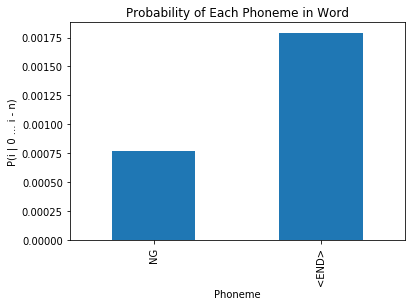

In [56]:
plot_pronunciation_probability(model, ('NG',))

In [41]:
(pronunciations.pronunciation == ('K', 'AH1', 'N', 'T', 'AH0', 'N')).sum()

0

In [37]:
plot_next_phoneme_distribution

False

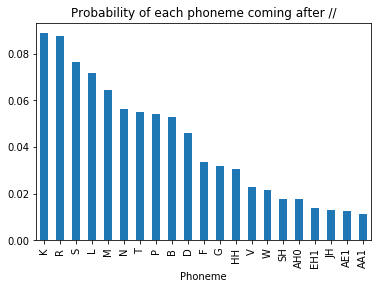

In [48]:
plot_next_phoneme_distribution(model, ())

In [62]:
%%time


param_grid = ParameterGrid({
    'embedding_dimension': [10, 50, 100],
    'hidden_dimension': [10, 50, 100],
})

records = []
for params in tqdm(param_grid):
    model_parameters = ModelParams(rnn_type='gru', num_layers=1, max_epochs=1000, early_stopping_rounds=1, **params)
    model = LanguageModel(vocab, model_parameters, device_name='cuda')

    print('Model Params:', model_parameters)
    
    train_losses, dev_losses = model.fit(
        train_pronunciations.pronunciation.values.tolist(),
        dev_pronunciations.pronunciation.values.tolist()
    )
    
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
        
        record['rnn_type'] = 'rnn'
        record['num_layers'] = 1 
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

Model Params: ModelParams(rnn_type='gru', embedding_dimension=10, hidden_dimension=10, num_layers=1, max_epochs=1000, early_stopping_rounds=1, learning_rate=0.001, dropout=0, l2_strength=0, batch_size=1024)
Epoch 1: train loss: 1.8375	dev loss: 2.1477
	Generated: in train: 1%, assess: 0%, novel: 99%
	 EH1
	 IH1 Y AH0
	 HH AE1
	 IH0 IY2 ER2 N OY2 AW2 ER2 OY0 L AH1 EY1 AO0
	 IH0 T TH IH0 AE2 AE2 EY0 IH2 AH1 OY2 CH HH AW1 S IY1
Epoch 2: train loss: 1.2120	dev loss: 1.5618
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AO1
	 CH TH AE1 IY0
	 IY1 AE2 EY0 V P EY0
	 F N AH1 AO2
	 AE1 IH2
Epoch 3: train loss: 1.0674	dev loss: 1.4100
	Generated: in train: 2%, assess: 0%, novel: 98%
	 HH AO2 UH0 AH0 V M L HH EY2 AO2
	 DH TH
	 P ER1 UW1 AH2 UH1 IY0 IH2 D
	 EH1 K D F JH AH1
	 B OY0 G AY2 D AH0 AH1
Epoch 4: train loss: 0.9821	dev loss: 1.3109
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AY0 AE0 CH AW0 B L IY1
	 DH UW1 T NG IH2
	 EH2 Z AY0 R R K UH1 EH0 ER1 AH1 Y
	 OY2 AY1 EY2 B AW2 AA1 L A

Epoch 42: train loss: 0.6623	dev loss: 0.9017
	Generated: in train: 6%, assess: 2%, novel: 92%
	 P L AW1 L AH0 V
	 M UW1 L IY0 AH0 L
	 S AH1 D IH0 NG S
	 S EH1 K IH0 N
	 S T EH0 EY1 L IH0 NG D
Epoch 43: train loss: 0.6615	dev loss: 0.9007
	Generated: in train: 7%, assess: 2%, novel: 91%
	 EH1 K IH0 JH
	 K EY1 N CH IH2 N Z Z
	 AE1 S K OW0
	 S W AA1 NG
	 B IH1 S T S
Epoch 44: train loss: 0.6608	dev loss: 0.8997
	Generated: in train: 8%, assess: 2%, novel: 90%
	 CH UW1 Z IH0 T AH0
	 G Y EY1 B ER0 Z AH0 L
	 P AH1 T SH AH0 L V IH0 NG
	 Z EH1 M AH0 N
	 F EH2 JH CH UW1 V
Epoch 45: train loss: 0.6601	dev loss: 0.8988
	Generated: in train: 12%, assess: 1%, novel: 87%
	 AH0 M AO1 N SH AH0
	 AE0 N IH0 D N IY1 T B
	 M IH0 OY1 CH
	 AA2 R UW2 P AA1 L M AH0 N
	 L AE1 T
Epoch 46: train loss: 0.6594	dev loss: 0.8980
	Generated: in train: 15%, assess: 1%, novel: 84%
	 OW0 Z AO1 NG N ER0
	 M AE1 G ER0 Z
	 B R AA0 T IH0 T IH0 N K EH1 L D AH0 N M ER0
	 S IH1 N IH0 NG Z
	 P ER1 D Z
Epoch 47: train loss: 0.6

Epoch 84: train loss: 0.6480	dev loss: 0.8833
	Generated: in train: 7%, assess: 0%, novel: 93%
	 B OW1 N UW0
	 HH EH1 R T UW2
	 HH EH1 D ER0 D
	 AA0 N S IH1 K AH0 N Z
	 F AA1 R
Epoch 85: train loss: 0.6479	dev loss: 0.8832
	Generated: in train: 11%, assess: 0%, novel: 89%
	 V ER0 S T AA1 N S K AA0 B ER0
	 W EY1 Z AH0
	 M ER1 G AH0
	 N IH0 K R AE2 R AH2 NG G AE0 P AH0 D
	 D AE1 K T S
Epoch 86: train loss: 0.6478	dev loss: 0.8830
	Generated: in train: 7%, assess: 1%, novel: 92%
	 P AA1 M P ER0
	 B OW1 L ER0 T
	 G AW1 Z B IY2
	 K AA1 R IH0 K F
	 AH0 SH IH0 JH AH1 N OW0
Epoch 87: train loss: 0.6477	dev loss: 0.8829
	Generated: in train: 9%, assess: 1%, novel: 90%
	 S IH1 NG K F AY0 N
	 L AH0 N T EH1 P AH0 S K IY0
	 UH0 R IY0 Z ER0 F IH1 L IH0 T IH0 NG
	 W EH2 L M IH1 S T IH0 NG
	 K AA1 R G AH0 L
Epoch 88: train loss: 0.6475	dev loss: 0.8827
	Generated: in train: 10%, assess: 0%, novel: 90%
	 OW0 K ER0 AA0 SH T AH1 S K IH0 K Z
	 CH AA0 L IH1 T Y AH0 N T W EY2 N EY0 Z
	 M AA1 K F AH0 N AH0 N

Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 1.0734	dev loss: 1.4382
	Generated: in train: 1%, assess: 0%, novel: 99%
	 AH0 AO1 D DH N
	 
	 DH AH0 AE1
	 EH0
	 TH IH1 K M AA0
Epoch 2: train loss: 0.9266	dev loss: 1.2532
	Generated: in train: 5%, assess: 0%, novel: 95%
	 K
	 D HH F
	 R IY0 IH0 AO2
	 T T
	 M Y
Epoch 3: train loss: 0.8454	dev loss: 1.1480
	Generated: in train: 3%, assess: 1%, novel: 96%
	 R IH0
	 K R ER0
	 OY2 T R M
	 ER1 UH1 R R IH0
	 B D K ER0 IY1 IY0
Epoch 4: train loss: 0.8018	dev loss: 1.0900
	Generated: in train: 2%, assess: 1%, novel: 97%
	 B R EY1 AA1 N UW2
	 K K R N EH1 EH1
	 N K N ER0
	 R S M L
	 N D M IY0 P M AH0
Epoch 5: train loss: 0.7732	dev loss: 1.0516
	Generated: in train: 2%, assess: 0%, novel: 98%
	 V AE1 SH
	 S AA1 R AO1 N
	 K UW1 N ER1 IY0 ER1 IH0 IY0
	 G AO1 M AH0
	 HH R G AA0 IY1 ER0 T
Epoch 6: train loss: 0.7518	dev loss: 1.0228
	Generated: in train: 1%, assess: 1%, novel: 98%
	 B K F AH0 N IY0
	 K
	 B AO1 T S OW1 R AH0 M IH0
	 R IH0 T AO1 N TH EY1 S
	 S AO1 R EH1 T M AH0 

Epoch 45: train loss: 0.6115	dev loss: 0.8363
	Generated: in train: 11%, assess: 0%, novel: 89%
	 HH EY1 B IH0 F AY2 L D
	 S AE1 CH ER0 OW0
	 F AE1 R IH0 T
	 F AY1 Z ER0
	 K AA1 R AH0 S
Epoch 46: train loss: 0.6110	dev loss: 0.8356
	Generated: in train: 12%, assess: 1%, novel: 87%
	 S T R OW1 M IH0 K
	 AE1 V R EH2 R S AH0 N
	 L UW1 B ER0 Z IY2 M
	 B R AY1 M AH0 N
	 S EH1 F ER0 S
Epoch 47: train loss: 0.6105	dev loss: 0.8350
	Generated: in train: 18%, assess: 0%, novel: 82%
	 K AA1 P IY0 AE0 M
	 AA0 P N EY1 AH0 T IY0
	 OW1 N M ER0
	 S EH1 S
	 HH AA1 G L AH0 T
Epoch 48: train loss: 0.6099	dev loss: 0.8344
	Generated: in train: 17%, assess: 3%, novel: 80%
	 Y UW1 L M AH0 N D
	 AH0 T UH1 R Z AH0 T AH0 L
	 W AA1 K S T AH0 L Z
	 B AA1 N D AH0 L Z
	 K AA1 K S AH0 L D Z
Epoch 49: train loss: 0.6096	dev loss: 0.8340
	Generated: in train: 8%, assess: 0%, novel: 92%
	 AA1 R IH0 N
	 S IH1 R AH0 B AH0 L IY0
	 S T OW1 IH0 G
	 AA1 R N AH0 T AH0 M
	 T W IH1 N SH AH0 W OW2
Epoch 50: train loss: 0.6091	

Epoch 87: train loss: 0.5991	dev loss: 0.8219
	Generated: in train: 9%, assess: 0%, novel: 91%
	 P R EH1 N S T
	 K AH0 M OW1 AH0 L
	 S K AA1 N OW0
	 V OY1
	 B IY1 ER0
Epoch 88: train loss: 0.5989	dev loss: 0.8216
	Generated: in train: 9%, assess: 3%, novel: 88%
	 K AH0 L AE1 P
	 R EH1 N ER0
	 B EY1 OW2 L IY2
	 P EY1 M
	 S T UW1 T R IY0 SH L IY0
Epoch 89: train loss: 0.5987	dev loss: 0.8216
	Generated: in train: 16%, assess: 1%, novel: 83%
	 R EH2 M IH1 JH IH0 T R IH0 K
	 AO2 R R AH0 V IH1 SH AH0 N V EY2 T IH0 V
	 R IH1 K AW0 T AH0 D
	 R AY1 L D AW2 N
	 W EH1 L F AW0
Epoch 90: train loss: 0.5987	dev loss: 0.8214
	Generated: in train: 9%, assess: 2%, novel: 89%
	 JH EY1 OW0
	 K AH1 P ER0 IH0 Z
	 F AH1 T F IH2 R
	 K AH0 M P IY1 N
	 P IY1 M Z
Epoch 91: train loss: 0.5984	dev loss: 0.8212
	Generated: in train: 19%, assess: 1%, novel: 80%
	 AA0 R B AA1 N IY0 AH0
	 AE2 N AH0 L AH0 M EH1 N L IY0 AH0
	 S IH1 D AH0 N
	 SH W AY1 N T ER0
	 OW1 L ER0 D
Epoch 92: train loss: 0.5983	dev loss: 0.8211


Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 0.9647	dev loss: 1.3038
	Generated: in train: 3%, assess: 0%, novel: 97%
	 CH AW1 Z T T M B Z R
	 AA1 ER0
	 IY0 OW0
	 NG M AA1 P
	 AW0 L F AE2 P R
Epoch 2: train loss: 0.8333	dev loss: 1.1333
	Generated: in train: 1%, assess: 0%, novel: 99%
	 AW0 AA1 N AO0 ER0
	 K EH1 L ER0 AH0 T AH0
	 OW0 AY1
	 IY0 R ER0 HH Z
	 EH1 S K IH1 L
Epoch 3: train loss: 0.7984	dev loss: 1.0867
	Generated: in train: 0%, assess: 0%, novel: 100%
	 K V AH0 M AH0 S AE1 OW0
	 T OW0 L AH0 N N ER0 T L T IH0 T S
	 ER1 OY2 P
	 IH0 IH1 AE1 D EH1 IY0 L IH0 D Z
	 S K IY1 W K SH
Epoch 4: train loss: 0.7720	dev loss: 1.0508
	Generated: in train: 2%, assess: 0%, novel: 98%
	 S T JH AH0 R
	 S AE1 L OW1 NG
	 EY1 EY1 ZH N
	 K EH1 V L IY0 ER0
	 F AE2 M AE2
Epoch 5: train loss: 0.7461	dev loss: 1.0156
	Generated: in train: 5%, assess: 0%, novel: 95%
	 F EH1 F B EH1 F D N
	 S S T EY1 AH0 IH1 S
	 B AH0 N IH0 TH IY0
	 G AO1 S AH0 AH0 N
	 F L D V Y AA1 L Z D
Epoch 6: train loss: 0.7235	dev loss: 0.9848
	Generated

Epoch 43: train loss: 0.5906	dev loss: 0.8124
	Generated: in train: 13%, assess: 3%, novel: 84%
	 N IH1 N AH0 M AH0 N
	 R AA1 Z IH0 Z EH2 T
	 AH0 T AA1 B AH0 M AH0 S IY0 Z
	 B AA1 R D
	 L UW1 V AH1 K ER0
Epoch 44: train loss: 0.5898	dev loss: 0.8115
	Generated: in train: 18%, assess: 3%, novel: 79%
	 W AO1 L S W AH0 S T
	 N IH1 Z IH0 NG
	 B EH1 L AH0 T
	 L UW1 B AH0 L
	 V IY1 Z
Epoch 45: train loss: 0.5889	dev loss: 0.8104
	Generated: in train: 15%, assess: 4%, novel: 81%
	 V AH0 G EY1
	 P EH2 R IY0 OW0 M IY1 L R AH0
	 P R AH0 B IH1 V AH0 S IH0 N
	 S T AY1
	 P R AH1 SH AH0 N IH0 T T
Epoch 46: train loss: 0.5883	dev loss: 0.8099
	Generated: in train: 9%, assess: 3%, novel: 88%
	 HH UW1 B ER0
	 R IH0 V IH1 T ER0 IH0 NG
	 HH EH1 S AH0 N
	 EH0 N AO1 NG G R IY0
	 M AA0 R IY0 EH1 N IY0
Epoch 47: train loss: 0.5877	dev loss: 0.8093
	Generated: in train: 13%, assess: 0%, novel: 87%
	 M OY1 CH ER0
	 S K UW1 D W ER2 TH
	 G EY1 B IY0 AH0
	 HH AA1 L IH0 B UH2 K
	 B IH1 B L IY0
Epoch 48: train loss

Epoch 86: train loss: 0.5731	dev loss: 0.7974
	Generated: in train: 7%, assess: 1%, novel: 92%
	 F R EH1 R OW0
	 M AH0 K S ER1 JH AH0 N T S
	 B UH1 G ER0 IH0 NG
	 B L AE1 S K IY0
	 S UW2 B IY1 N AH0
Epoch 87: train loss: 0.5729	dev loss: 0.7974
	Generated: in train: 10%, assess: 4%, novel: 86%
	 M IH1 S T R IY0 IH0 NG
	 S W ER1 T IH0 NG
	 K R AE1 M S K IY0
	 K AE0 P T ER0 M IH1 N SH AH0 N
	 D AO1 R N IH0 K
Epoch 88: train loss: 0.5727	dev loss: 0.7973
	Generated: in train: 17%, assess: 1%, novel: 82%
	 OW2 N IY0 K L AH0 B EY1 SH AH0 N
	 M AA0 N AO1 K AH0
	 K L EH1 R IH0 SH
	 D IY1 TH AH0 Z
	 B R AE1 D Z
Epoch 89: train loss: 0.5725	dev loss: 0.7971
	Generated: in train: 17%, assess: 2%, novel: 81%
	 N EH1 P T
	 G OW1 B ER0
	 D IY1 M IH0 JH
	 IH0 K S P L EH1 K S IH0 Z
	 S AY2 K EY1 N Z
Epoch 90: train loss: 0.5723	dev loss: 0.7970
	Generated: in train: 18%, assess: 1%, novel: 81%
	 IH0 K L IY1 S IH0 V
	 K AH0 N V EH1 S T R AH0 N S
	 IH1 N S T ER0 Z
	 B AY1 Z K OW0
	 OW1 B ER0 L IH0 G IH

Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 2.3281	dev loss: 2.5659
	Generated: in train: 4%, assess: 0%, novel: 96%
	 T IY0 OW2 P UH2 ER0 N AH2 R ER1 AY0 ER0 Z ZH ER1 AW2 AH1 JH S CH N AO1 OW0 EY0 ER1 UW2 UW0 UH2 AO2 S T IH2 D
	 ZH OW1 AH1 G Y D UW2 AH1 S UW0 AW0 AO2 AY0 AY2 UW2 IH0 F R HH OW0 V ER1 AA0 IH2 EY1 IY2 EH0 M AO1 AW1 G IY2 V
	 OW2 T G AY1
	 EY1 AO0 EY2 IH0 DH
	 R ER0 IH1 ZH UH0 AE1 EY0 UW1 AO0 UW0 UW1 AO0 JH EY2 OY2 AH2 Z OW2 AE2 D EY0
Epoch 2: train loss: 1.3737	dev loss: 1.6853
	Generated: in train: 6%, assess: 0%, novel: 94%
	 AY1 L N N AH1
	 EH1 OY0 AH1 AO0 UH1
	 AE2 N CH N T
	 OY0 AA0
	 M AY0 R B
Epoch 3: train loss: 1.0913	dev loss: 1.4068
	Generated: in train: 4%, assess: 0%, novel: 96%
	 AE0 ZH UW0 AO2 IH0
	 AO0 UW0 AH0 B
	 AO2 D
	 UW2 AO0
	 AH0
Epoch 4: train loss: 0.9783	dev loss: 1.2876
	Generated: in train: 6%, assess: 0%, novel: 94%
	 OW2 Y L
	 T ER0
	 ER1 UW0
	 EH1 CH AA1 K AW0 S AO2 AH1
	 N AW1 UW0 ER1 AO2 AH2 UH0 S L AY2
Epoch 5: train loss: 0.9166	dev loss: 1.2189
	Generated: in

Epoch 41: train loss: 0.6620	dev loss: 0.9016
	Generated: in train: 11%, assess: 1%, novel: 88%
	 B R AE2 K IH0 OW0 N IY1 IY2 G OW2 L OW2 N Z
	 AA0 R UW1 N D
	 K AA1 M L D
	 S T ER0 AA1 K
	 AE1 D AA2 IY0 N EH2 P
Epoch 42: train loss: 0.6613	dev loss: 0.9007
	Generated: in train: 13%, assess: 1%, novel: 86%
	 N EH1 L M AH0 HH AH0 L
	 M EH1 N IH0 Z
	 R AH1 L AW0 ER0
	 JH AA1 B AH0 L
	 AO1 F IY0
Epoch 43: train loss: 0.6605	dev loss: 0.8997
	Generated: in train: 7%, assess: 1%, novel: 92%
	 B IH1 L AH0 B AH0 N
	 K R AE1 N AH0 N
	 M IH1 L AH0 S ER0 T
	 D L EY1 CH
	 AW1 N B
Epoch 44: train loss: 0.6599	dev loss: 0.8989
	Generated: in train: 10%, assess: 2%, novel: 88%
	 P IH1 N D D IH0 L
	 IH0 Z R AY1 V AH0 N IH0 NG
	 F AA1 T P ER0 Z
	 EY1 ER0 AH0
	 B ER1 N AH0 NG
Epoch 45: train loss: 0.6592	dev loss: 0.8981
	Generated: in train: 15%, assess: 1%, novel: 84%
	 AA0 R D G Y UH2 P AE1 K IY0
	 V AH1 N AH0 N
	 B R AY0 IH1 N P IY0
	 EY2 K AH0 L
	 TH AE1 T S ER0 IH0 S Z
Epoch 46: train loss: 0.658

Epoch 83: train loss: 0.6456	dev loss: 0.8803
	Generated: in train: 8%, assess: 0%, novel: 92%
	 JH IH0 P IY1 F AH0 N
	 G UW1
	 N EH2 R IY0 R UW1 IY0
	 HH R AE1 M
	 K Y UW1 SH AH0
Epoch 84: train loss: 0.6453	dev loss: 0.8799
	Generated: in train: 15%, assess: 1%, novel: 84%
	 IY2 SH L UW1 F IY0
	 K EH1 R IH0 K
	 AH0 JH AY2 S T IY0 R AH0 Z AO1 R Z
	 HH AY1 M
	 Z EY1 JH IH0 K L AH0 N
Epoch 85: train loss: 0.6451	dev loss: 0.8797
	Generated: in train: 12%, assess: 2%, novel: 86%
	 T EH1 L AH0 S
	 B AA2 L AA1 N AH0 G ER0
	 CH UH1 D L IH0 Z
	 S W EH1 N T
	 S T IH1 P IY2 D IH0 NG
Epoch 86: train loss: 0.6450	dev loss: 0.8795
	Generated: in train: 9%, assess: 1%, novel: 90%
	 T W AW1 N D
	 R AA2 B EH0 F AA1 S T AH0 N
	 HH AA1 R P
	 B AO2 R EH2 N T S T R AH0 L L IH1 N AH0 N
	 M AO1 IH2 P S
Epoch 87: train loss: 0.6448	dev loss: 0.8792
	Generated: in train: 7%, assess: 2%, novel: 91%
	 P EH1 R AH0 S M AH0 N
	 S IY1 P AA0 Z
	 G R AE1 N ER0
	 F L IY0 IH2 K AH0 N OY1 V
	 S K L AH0 T EH1 TH B ER0 

Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 0.9862	dev loss: 1.3290
	Generated: in train: 1%, assess: 0%, novel: 99%
	 UH2 AA2 EY0 OW2 AH2 UW1
	 AY2 M IY2 HH AE0 K
	 OW1 G IH2 R
	 AO1 IY1 IY0
	 S IH0 HH AW0 R UW0 EH1 EY2
Epoch 2: train loss: 0.8288	dev loss: 1.1237
	Generated: in train: 2%, assess: 0%, novel: 98%
	 IH2 OW0 N UH2 AW1 G OY2 AY2 R V D
	 R AH0 Z N
	 OW1 EH0 ER1 D N Z
	 K Y K G K
	 AA0 AH0 N AA1 N IH1 AH0 N T S
Epoch 3: train loss: 0.7669	dev loss: 1.0417
	Generated: in train: 2%, assess: 0%, novel: 98%
	 M L IH1 SH
	 HH Z AH0 M IY0 P
	 R AH0 S
	 S N L AA0 D HH AH0 R
	 AO2 AW2 R SH AH1 R AH0 AY1 AO1 IY0 AA1 N
Epoch 4: train loss: 0.7267	dev loss: 0.9878
	Generated: in train: 3%, assess: 0%, novel: 97%
	 R IH1 G N TH
	 L AY2 S Y ER0
	 G F AY1 N AH0 T
	 V ER0 S N IH0 K AE1 N IH0 UW1 D
	 L W OY0 K T AY1 ER0 AH0 T
Epoch 5: train loss: 0.6986	dev loss: 0.9501
	Generated: in train: 7%, assess: 0%, novel: 93%
	 IH2 M EY1 T
	 AO1 F R UW1
	 G IH1 M AO1
	 W UW1 K L
	 B IY0 EH0 F
Epoch 6: train loss: 0.6807

Epoch 44: train loss: 0.5965	dev loss: 0.8180
	Generated: in train: 8%, assess: 1%, novel: 91%
	 M AA0 R HH AE1 N Z
	 TH R IY1 P
	 S T R UW1 V IH0 NG
	 TH AA1 S IY0
	 K OW1 S
Epoch 45: train loss: 0.5961	dev loss: 0.8177
	Generated: in train: 12%, assess: 1%, novel: 87%
	 M AO1 L S AH0 L
	 T AW1 P L IH2 NG K
	 S IY0 R EH1 L V AH0
	 B EY1 L ER0
	 T Y IH1 K S
Epoch 46: train loss: 0.5956	dev loss: 0.8171
	Generated: in train: 12%, assess: 0%, novel: 88%
	 SH R AY1 B D
	 Y AO1 R
	 IH0 N HH AY1 W IY2 N
	 F R EH1 T S
	 S AW1 T L IH0 K AY2 N
Epoch 47: train loss: 0.5953	dev loss: 0.8167
	Generated: in train: 9%, assess: 2%, novel: 89%
	 JH UW1 N AH0 T W UH2 Z
	 K AA1 R T W UH2 L IY0
	 T R UW2 D AA1 F ER0 Z
	 K AE1 S T R AH0
	 K L OW1 S T
Epoch 48: train loss: 0.5949	dev loss: 0.8164
	Generated: in train: 11%, assess: 2%, novel: 87%
	 TH AW1 AH0 L
	 CH IH1 T IH0 S
	 IH2 M P R EY1 N
	 T AY1 Z AH0 N
	 M AO1 S T
Epoch 49: train loss: 0.5944	dev loss: 0.8158
	Generated: in train: 8%, assess: 0%, 

Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 0.8523	dev loss: 1.1572
	Generated: in train: 3%, assess: 0%, novel: 97%
	 EH0 OW1 L ER1 R EY2 S IH1 G L IY0 N R
	 AA2 AE1 ER0 T AY0 D
	 G AH0 OY2
	 AA0 OY2
	 Z
Epoch 2: train loss: 0.7608	dev loss: 1.0350
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AA1 R R M ER1 N IY0 R
	 AH0 L T K S NG
	 V OW1 IY0 L AH0 N
	 M SH ER0
	 AW1 W L AE1 Z
Epoch 3: train loss: 0.7017	dev loss: 0.9551
	Generated: in train: 5%, assess: 0%, novel: 95%
	 AE1 Y IY0 T AE1 N
	 V EH1 N AH0 Z B AH0 T
	 HH IH1 Z L AH0 N
	 N AY1 M AH0 K
	 W ER2 AO1 R IY0
Epoch 4: train loss: 0.6713	dev loss: 0.9143
	Generated: in train: 10%, assess: 1%, novel: 89%
	 B R AO1 L OW0
	 F AO1 L M N
	 Y AH0 T IY1 N D AH0 S
	 P AE1 L IH0 L T IY0
	 V B UH0 UH1 NG
Epoch 5: train loss: 0.6550	dev loss: 0.8925
	Generated: in train: 6%, assess: 3%, novel: 91%
	 L AA1 M JH AH0 S EY2 L D
	 OW1 Z AH0 L
	 JH AY1 F AH0 L IY0
	 G IH1 S M Z IH0 N JH
	 G R IH0 K W IH1 V T IY1 K
Epoch 6: train loss: 0.6443	dev loss: 0.8782
	Gene

	Generated: in train: 10%, assess: 0%, novel: 90%
	 B ER1 G AH0 L
	 AH0 M AA1 N T ER0
	 S K R IH1 CH W AE2 K
	 G R AE1 F IY0
	 EH2 T N IH1 K OW0
Epoch 44: train loss: 0.5721	dev loss: 0.7936
	Generated: in train: 15%, assess: 2%, novel: 83%
	 G OW1 D AH0 L
	 S AY1 Z AH0 N Z
	 AH0 K R IY1 V IH0 NG
	 B Y UH0 R EY1 D AH0
	 V IY1 L P
Epoch 45: train loss: 0.5717	dev loss: 0.7932
	Generated: in train: 24%, assess: 1%, novel: 75%
	 TH EY1 N L AH0 N D
	 D IH0 S IY1 L
	 K L EH1 N V W EH0 DH ER0
	 AW1 IH0 NG Z ER0
	 IH2 D W IH1 SH AH0 N
Epoch 46: train loss: 0.5711	dev loss: 0.7928
	Generated: in train: 14%, assess: 7%, novel: 79%
	 D IH1 P
	 IH1 NG G L ER0
	 W AY1 Z D AH0 N
	 W IH1 L K AH0
	 K L EH1 K T
Epoch 47: train loss: 0.5706	dev loss: 0.7925
	Generated: in train: 11%, assess: 3%, novel: 86%
	 F AA1 N IH0 K M AH0 N
	 T R IH1 K AH0 T EY2 T IH0 D
	 AE0 M F IH1 S AH0 N EY1 Z
	 F R EH1 L D
	 P R IY1 F ER0
Epoch 48: train loss: 0.5701	dev loss: 0.7919
	Generated: in train: 10%, assess: 2%, no

Epoch 86: train loss: 0.5591	dev loss: 0.7863
	Generated: in train: 15%, assess: 1%, novel: 84%
	 M AH1 L B ER0
	 M IY1 N AH0 N S IH0 Z
	 K R AA1 K L AH0 S
	 CH AH0 V IY1 N IY0
	 HH OW1 T IH0 K
Epoch 87: train loss: 0.5587	dev loss: 0.7860
	Generated: in train: 14%, assess: 1%, novel: 85%
	 S EY1 V ER0 S AH0 N
	 R AH1 M L IH0 NG
	 W AO1 R B R IH0 K
	 K UH1 P SH AW0
	 G L AE1 R IH0 N
Epoch 88: train loss: 0.5585	dev loss: 0.7860
	Generated: in train: 22%, assess: 4%, novel: 74%
	 R EH1 SH IY0 IH2 Z AH0 M
	 R AH1 K
	 L AA1 R EH2 S
	 S IH1 M F AH0 S
	 K L AE1 K P AY2 S IH0 NG
Epoch 89: train loss: 0.5583	dev loss: 0.7858
	Generated: in train: 22%, assess: 1%, novel: 77%
	 Z AY1 B ER0
	 D IH0 N EH1 T AH0 N S
	 W AA1 D L Y AH0 B AH0 L
	 K R IH1 S AE2 K
	 L IH1 T ER0
Epoch 90: train loss: 0.5580	dev loss: 0.7856
	Generated: in train: 16%, assess: 0%, novel: 84%
	 R AW1 L
	 EH1 V ER0 IH0 S
	 D IH0 S K AO1 F S K IY0
	 P R IH0 P OW0 R AA1 B OW0
	 P AA1 L P IH0 SH
Epoch 91: train loss: 0.5580	de

Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 2.2418	dev loss: 2.4689
	Generated: in train: 1%, assess: 0%, novel: 99%
	 AH0 AH1 TH IY1 OW0 DH AE1 UW2 JH AW0 Y OW2 UW2 IY2 AH1 M K AO2 DH AW0 EY0 R TH EH1 AE1 AA0 IH2
	 DH
	 V M HH IH1 UW0 SH IH0 F EH1 UH0 ZH IY2 DH AW2 AW0 IY2 OY1 AW2 ER2 UH0 AW0 AA2 AA0 UW1 Z ER2 NG S EH2 OW1 IH0
	 DH Y AO0 AE1 AH2 TH OW2 AO0
	 DH AW1 OW2 AA2 AA0
Epoch 2: train loss: 1.3419	dev loss: 1.6377
	Generated: in train: 4%, assess: 0%, novel: 96%
	 
	 NG R OY0 ER0 AE0 V W IY1 G AH0
	 
	 F IH0 F
	 V L K IY1 OW2 EH1 AE2 OY0 ER0 AY0 TH AA1 F AE2 P IY1 W AY0 UW1 AW1 AO1 L EH2 AA1 AW1 AW2
Epoch 3: train loss: 1.0626	dev loss: 1.3644
	Generated: in train: 4%, assess: 0%, novel: 96%
	 OY0 NG AH0 D S
	 M K AW0 B K
	 EH1 S
	 NG P G
	 F F EH0 UH1 EY0 T T ZH ER1 OY1
Epoch 4: train loss: 0.9479	dev loss: 1.2434
	Generated: in train: 3%, assess: 0%, novel: 97%
	 B EH1 S ER0
	 ER0 L AE2 N AW2 UH2 AY0 N TH
	 L R OY1 ER0
	 ER1 EH0 N P UH0 UH2 EH0 AA1 T TH AW0
	 L IH1 B G
Epoch 5: train loss: 0.8841	d

Epoch 42: train loss: 0.6631	dev loss: 0.9035
	Generated: in train: 4%, assess: 1%, novel: 95%
	 P R EH1 S P ER0 V Z
	 AE1 P AH0 N D
	 IY0 IY1 N AE2 T Z
	 D AH0 P IY1 AE2 M AH0 T IH0 Z
	 AE1 NG HH OW2 D
Epoch 43: train loss: 0.6624	dev loss: 0.9026
	Generated: in train: 10%, assess: 4%, novel: 86%
	 K AA1 L AH0
	 M AW1 M
	 W AA1 G
	 JH W AY2 T EH1 D AH0 N
	 EH1 L AH0
Epoch 44: train loss: 0.6615	dev loss: 0.9014
	Generated: in train: 10%, assess: 2%, novel: 88%
	 D AH1 T R IH0 K AH0 L
	 B AA1 N L AH0 M
	 K IY1 S W AH1 N T
	 M AH0 M IH1 NG K IY0
	 CH IY1 N
Epoch 45: train loss: 0.6608	dev loss: 0.9005
	Generated: in train: 13%, assess: 2%, novel: 85%
	 G AH1 M IH0 N
	 S AE1 K AH0 JH IH0 B S
	 V ER1 D IH0 NG
	 B EH1 R T AH0 G N OW0
	 L AH1 S T
Epoch 46: train loss: 0.6600	dev loss: 0.8996
	Generated: in train: 9%, assess: 3%, novel: 88%
	 M L AA1 R B ER0 ER0
	 T R OW1 N Z
	 B ER1 P P
	 F IH1 K AH0 S
	 S P R AY1 R
Epoch 47: train loss: 0.6593	dev loss: 0.8986
	Generated: in train: 9%, ass

Epoch 85: train loss: 0.6478	dev loss: 0.8836
	Generated: in train: 16%, assess: 3%, novel: 81%
	 JH ER1 N AH0 L Z
	 HH AO1 L N ER0
	 K L EY1 L D T
	 AH1 L T IH2 N
	 M AH0 N IH1 N JH IY0
Epoch 86: train loss: 0.6477	dev loss: 0.8834
	Generated: in train: 12%, assess: 1%, novel: 87%
	 P IH1 N IH1 D T AH0 M
	 JH AH1 L TH AH0 N Z
	 D IH1 B ER0 OW2 D ER0
	 R EY1
	 SH AA1 L AH0
Epoch 87: train loss: 0.6475	dev loss: 0.8833
	Generated: in train: 11%, assess: 2%, novel: 87%
	 B EH1 N TH R OW0 N T
	 K AE1 Y UW0 K OW2 L
	 K OW1
	 D AO1 R D ER0
	 T EH1 AH0 N IY0 AH0
Epoch 88: train loss: 0.6475	dev loss: 0.8831
	Generated: in train: 14%, assess: 2%, novel: 84%
	 B L AE1 S T ER0
	 P R IH0 N IY1 Z
	 AH1 SH AH0 N N OW0
	 HH IH1 S CH AH0 L
	 B ER2 K EY1 S P IY2 N S IH0 D T R IY0
Epoch 89: train loss: 0.6474	dev loss: 0.8830
	Generated: in train: 13%, assess: 5%, novel: 82%
	 B IH1 N S AH0 N Z
	 R OW1 Z
	 B IH0 L IH0 B UH1 L IY2
	 AO2 S IH2 L IY0 AW1 P
	 S AA1 M
Epoch 90: train loss: 0.6472	dev loss:

Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 0.8975	dev loss: 1.2100
	Generated: in train: 2%, assess: 1%, novel: 97%
	 K N AH0 AH0 S
	 S P HH P UH0 R Z
	 EH2 AY1
	 OW1 AY2 AY1 AH0 N
	 S R L IH1 AO2 P L F IY0
Epoch 2: train loss: 0.7873	dev loss: 1.0673
	Generated: in train: 6%, assess: 0%, novel: 94%
	 HH M P ER0 IY0
	 L
	 AW1 EH1 L
	 AA1
	 L AE1 SH AE1 L AH0 AE1 R AA1 CH
Epoch 3: train loss: 0.7318	dev loss: 0.9937
	Generated: in train: 2%, assess: 0%, novel: 98%
	 B EH2 B AE0 N K ER0
	 D L OW1 P T
	 B F K EY1 S ER0
	 SH IY0 K
	 S B AH0 M AA1 L JH AH0 M N
Epoch 4: train loss: 0.6991	dev loss: 0.9503
	Generated: in train: 5%, assess: 0%, novel: 95%
	 L IY0 L IY1 L
	 P R AA1 L Z
	 D R AA1 M R IY0
	 EY2 T IH1 N
	 EH1 S AO1 L Z
Epoch 5: train loss: 0.6787	dev loss: 0.9234
	Generated: in train: 6%, assess: 1%, novel: 93%
	 AH0 G AE1 AH0 L AH0 N
	 N CH IY1 S M
	 SH EY1 HH IH0 N
	 AY1 R
	 AY1 K EY0 T
Epoch 6: train loss: 0.6653	dev loss: 0.9057
	Generated: in train: 7%, assess: 1%, novel: 92%
	 S OW1 JH ER0 OW0
	 

Epoch 44: train loss: 0.5937	dev loss: 0.8159
	Generated: in train: 17%, assess: 1%, novel: 82%
	 L OW0 DH IY1 T
	 F R AA1 N IY0 G AA2 M S ER0
	 S IH2 N AH0 D EY1 D
	 P R OW0 S N IH1 SH AH0 N Z
	 K AE1 N AH0 L
Epoch 45: train loss: 0.5932	dev loss: 0.8154
	Generated: in train: 11%, assess: 4%, novel: 85%
	 TH IH2 S T AH0 L IH0 S T R EH1 S IH0 N
	 HH EH1 R JH UW0
	 S IH1 P R IH0 K
	 M AH0 G R EY1 L Z
	 B AA1 R D N ER0
Epoch 46: train loss: 0.5929	dev loss: 0.8150
	Generated: in train: 18%, assess: 2%, novel: 80%
	 AO1 N B IH0 K
	 AA1 L B Y AA2 N
	 D AY1 ER0
	 K AH1 S IY0
	 K IH1 K Y AH0 N T S L IY0
Epoch 47: train loss: 0.5925	dev loss: 0.8147
	Generated: in train: 13%, assess: 0%, novel: 87%
	 R EH2 S T N AA1 K AH0 L V IH0 NG Z
	 D EY1 Z AH0 HH IY0
	 AO0 G W AY1 ER0 D
	 K UW1 D ER0
	 M AA1 R T IH0 D IY0
Epoch 48: train loss: 0.5921	dev loss: 0.8142
	Generated: in train: 14%, assess: 2%, novel: 84%
	 D R EH1 TH
	 D IH1 S M AH0 N
	 M AH0 K AH1 M P AH0
	 L AO1 D
	 P ER0 G ER1
Epoch 49: tr

Epoch 86: train loss: 0.5847	dev loss: 0.8073
	Generated: in train: 14%, assess: 2%, novel: 84%
	 P R AA2 S AH0 N IH1 S T IH0 K
	 IH2 N V R AH1 K T IH0 K
	 B EH1 Z D IY0
	 M AA2 S AH0 N AA1 N AH0 N
	 Z AE1 F AH0
Model Params: ModelParams(rnn_type='gru', embedding_dimension=100, hidden_dimension=100, num_layers=1, max_epochs=1000, early_stopping_rounds=1, learning_rate=0.001, dropout=0, l2_strength=0, batch_size=1024)


Early stopping because of no decrease in 1 epochs.


Epoch 1: train loss: 0.8296	dev loss: 1.1255
	Generated: in train: 3%, assess: 1%, novel: 96%
	 EH0
	 R B IY0 N
	 AA1 IY1 IH2 L AH0 UH1 IY0 AH0
	 F AY1 AH0
	 AE0 AY2 SH UW0 T ER0
Epoch 2: train loss: 0.7258	dev loss: 0.9873
	Generated: in train: 6%, assess: 0%, novel: 94%
	 ZH AE1 N R IY0 IH0 AH0 N S
	 S V EY1 L AH0 T IH0 K L ER0
	 V JH W W IH0 N
	 L AA1 S T S
	 S IY0 IH0 B IH0 L AY0
Epoch 3: train loss: 0.6786	dev loss: 0.9241
	Generated: in train: 11%, assess: 0%, novel: 89%
	 T L AE1 K S EH0 IY2 L IY0
	 SH AH1 AA0 G B EH2 G
	 B IY1 B B ER0 Z
	 G AH0 NG L AA1 S
	 B R IY1 D
Epoch 4: train loss: 0.6561	dev loss: 0.8940
	Generated: in train: 6%, assess: 1%, novel: 93%
	 R G IH0 V AO1 K AH1 V IY0 Z
	 L AO1 R AH0
	 R EY1 SH AH0 N
	 S AW1 R AH0 N Z
	 AH0 N UW1 N P R EY1 N AH0 N
Epoch 5: train loss: 0.6433	dev loss: 0.8771
	Generated: in train: 15%, assess: 2%, novel: 83%
	 SH N Y UW1 Z
	 AH0 JH EH1 V K
	 EH1 N IH0 T
	 B R EY1 V ER0 Z
	 V AE1 N T EY1 AH0
Epoch 6: train loss: 0.6340	dev loss

Epoch 44: train loss: 0.5696	dev loss: 0.7920
	Generated: in train: 16%, assess: 1%, novel: 83%
	 G HH AA2 R AH0 T R IH1 L IH0 JH IH0 S T
	 AH0 G R IY1 S
	 S W AO2 T F EH1 K W AO2 L
	 F EH1 T AH0 N
	 M AA1 B K OW0
Epoch 45: train loss: 0.5691	dev loss: 0.7916
	Generated: in train: 12%, assess: 2%, novel: 86%
	 P AA1 N S IH0 K
	 P AH1 L M AH0 N
	 G AA1 R S M AO0 N
	 K AA2 N T AH0 G AY1 V
	 AE1 K IH0 S IH0 S
Epoch 46: train loss: 0.5685	dev loss: 0.7910
	Generated: in train: 15%, assess: 1%, novel: 84%
	 B R AO1 N T AE2 K
	 B R IH1 K
	 K AH0 T IH1 SH AH0 N Z
	 L UW1 S M AH0
	 HH W EH1 S
Epoch 47: train loss: 0.5683	dev loss: 0.7911
	Generated: in train: 9%, assess: 2%, novel: 89%
	 W IH1 M B IY0
	 S T IH1 N D ER0
	 W AA1 N D AH0 N B UH2 K
	 B OW0 N IY1 M Y AH0 N
	 L AO1 R AH0 N
Epoch 48: train loss: 0.5677	dev loss: 0.7907
	Generated: in train: 9%, assess: 2%, novel: 89%
	 S T R EY1 N
	 S IH1 N IH0 NG ER0
	 D IH1 R
	 AE1 G AH0 T IH0 B Y OW0 T S
	 B IY1 M OW0
Epoch 49: train loss: 0.5673	

Epoch 86: train loss: 0.5572	dev loss: 0.7860
	Generated: in train: 14%, assess: 0%, novel: 86%
	 HH OW1 L T ER0
	 D AO1 R IY0 AH0 S
	 S AW2 T W EH1 Z
	 AO2 R AH0 M EH1 T IH0 K S
	 B AA1 R CH AH0 K ER0
Epoch 87: train loss: 0.5569	dev loss: 0.7858
	Generated: in train: 12%, assess: 2%, novel: 86%
	 V EY1 N T F IY2 L IY0
	 D EH0 N T R AY1 AH0 L IY0
	 JH AA1 CH
	 HH OW1 Z IH0 N
	 B EY1 B IY0 ER0
Epoch 88: train loss: 0.5567	dev loss: 0.7859
	Generated: in train: 14%, assess: 2%, novel: 84%
	 P IY1 K OW0
	 K AH0 M N IY1 N Y UW0
	 P R AY1 M B EY2 L
	 F UH1 T IH0 D L IH0 S
	 K R AH0 M AE1 T IH0 K
Epoch 89: train loss: 0.5565	dev loss: 0.7858
	Generated: in train: 18%, assess: 1%, novel: 81%
	 D IH0 R EH1 K T AH0 B AH0 L
	 AE1 L IY2 S AH0
	 W IY1 Z
	 K R EY1 S
	 S P EH1 K T
Epoch 90: train loss: 0.5565	dev loss: 0.7858
	Generated: in train: 20%, assess: 2%, novel: 78%
	 D EH1 S T ER0 D IH2 Z AH0 M
	 S K OW1 P IH0 N AA2 N
	 P AA2 R IY1 S AH0 N
	 V AE1 N IH0 L ER0
	 B L EH1 K S M AH0 N
Epoch 9

Early stopping because of no decrease in 1 epochs.


In [66]:
models_df.sort_values('dev_loss', inplace=True)

In [72]:
len(models_df)

847

In [75]:
models_df[models_df.dev_loss < .79].drop_duplicates(['embedding_dimension', 'hidden_dimension'])

,embedding_dimension,hidden_dimension,epoch,train_loss,dev_loss,rnn_type,num_layers
569,50,100,90,0.557959,0.785609,rnn,1
841,100,100,87,0.556947,0.785834,rnn,1


In [76]:
models_df

,embedding_dimension,hidden_dimension,epoch,train_loss,dev_loss,rnn_type,num_layers
569,50,100,90,0.557959,0.785609,rnn,1
570,50,100,91,0.558013,0.785817,rnn,1
841,100,100,87,0.556947,0.785834,rnn,1
844,100,100,90,0.556460,0.785845,rnn,1
568,50,100,89,0.558278,0.785846,rnn,1
...,...,...,...,...,...,...,...
572,100,10,2,1.341918,1.637736,rnn,1
294,50,10,2,1.373661,1.685324,rnn,1
0,10,10,1,1.837496,2.147702,rnn,1
571,100,10,1,2.241816,2.468859,rnn,1


In [2]:
models_df.to_csv('models_df_tuesday.csv')

NameError: name 'models_df' is not defined

In [ ]:
models_df[models_df.embedding_dimension==100].sort_values('dev_loss')

In [ ]:
models_df[(models_df.embedding_dimension==10) & (models_df.hidden_dimension==3)].sort_values('dev_loss')

In [ ]:
models_df = pd.read_csv('models_df_tuesday.csv')

In [ ]:
models_df.sort_values('dev_loss')

In [ ]:
%%time


param_grid = ParameterGrid({
    'embedding_dimension': [50],
    'hidden_dimension': [2],
})

records = []
for params in tqdm(param_grid):
    model_parameters = ModelParams(rnn_type='rnn', num_layers=1, max_epochs=1000, early_stopping_rounds=1, **params)
    model = LanguageModel(vocab, model_parameters, device_name='cpu')

    print('Model Params:', model_parameters)
    
    train_losses, dev_losses = model.fit(
        train_pronunciations.pronunciation.values.tolist(),
        dev_pronunciations.pronunciation.values.tolist()
    )
    
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df = pd.DataFrame.from_records(records)

There are {meow} models with a dev error of around .76. I'll choose the simplest one, which 

* point out that no matter how low the train error gets, the dev error
* which model parameters fail to ever get to the lowest dev error
* which model parameters overfit the most

* isolate the group of models with about .76 dev error. choose the simplest one.

In [ ]:
t = models_df[(models_df.embedding_dimension==50) & (models_df.hidden_dimension==100) & (models_df.num_layers==3)]
t = t.set_index('epoch')
t.dev_loss.plot()
t.train_loss.plot()
_ = plt.legend()

In [ ]:
models_df.sort_values('dev_loss').iloc[0]

Since the best "model" was at an earlier epoch I don't have access to it. So I'll train a model with that model's parameters and set the number of epochs to MEOW.

In [ ]:
%%time

model = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=50, hidden_dimension=100, num_layers=3,
    max_epochs=69, early_stopping_rounds=69, batch_size=1024,
)

train_loss, dev_loss = model.fit(train_df.pronunciation.values.tolist(), dev_df.pronunciation.values.tolist())

Now that I have what I hope is the best model I can test how well it does on the holdout test set, which I haven't look at at all during the training process.

In [ ]:
test_loader = build_data_loader(test_df.pronunciation.values.tolist(), lm.phoneme_to_idx)
lm.evaluate(test_loader)

In [ ]:
dev_loader = build_data_loader(dev_df.pronunciation.values.tolist(), lm.phoneme_to_idx)
lm.evaluate(dev_loader)

TODO: compute the test error for the final model. Bar chart for the train, dev, and test errors

Comment on findings, probably that test is higher and that's expected because language models are very sensitive to corpus difference (and I probably overfit the dev set)

## Training the Final Model ##
Now that I've found the best parameters for the model according to the dev set I'll train a final model using all of the data. This should increase model performance overall since more data is better, but is also necessary since I'll be using the model to predict probabilities of all English words. If some of those words weren't in the training set they would artificially get lower probabilities. (Another approach here could be to train a model on e.g. 4/5 folds of the data and make predictions about the remaining 1/5, doing that 5 times to get unbiased predictions for all data, but this would have taken much longer to run.)

In [3]:
%%time

model_params = ModelParams(
    rnn_type='gru', embedding_dimension=50, hidden_dimension=50, num_layers=1,
    max_epochs=3, early_stopping_rounds=3, batch_size=1024
)

language_model = LanguageModel(vocab, model_params, device_name='cpu')

_ = language_model.fit(pronunciations.pronunciation.values)

NameError: name 'ModelParams' is not defined

And finally, I'll save the model so I can use it in the next notebook, `Phoneme Exploration.ipynb`.

In [ ]:
with open('phoneme_language_model.pt', 'wb') as fh:
    model.save(fh)

In [2]:
pd

NameError: name 'pd' is not defined